# Predcition of Hospital Admission Related to Upper Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to upper respiratory tract infection (URTI).

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_date_'+str(i), 'urti_ab_date_'+str(i), 'urti_ab_type_'+str(i),
                   'incdt_urti_date_'+str(i), 'admitted_urti_date_'+str(i), 'sgss_gp_cov_urti_date_'+str(i)]]
    
    #drop rows with no urti reord
    datum = datum[datum['urti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_i
    datum = datum[datum['sgss_gp_cov_urti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_date_'+str(i): 'urti_date', 'urti_ab_date_'+str(i): 'urti_ab_date', 
                           'urti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_date_'+str(i): 'incdt_urti_date', 'incdt_urti_type_'+str(i): 'incdt_urti_type',
                           'admitted_urti_date_'+str(i): 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_'+str(i): 'sgss_gp_cov_urti_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req_enc#data_req_enc, #data_req

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of cases with antibiotic prescription
def make_summary_table_cases(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_cases = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical cases data
    data_cases = data_cases[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period', 'antibacterial_brit', infection+'_ab_date']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_cases_enc = pd.DataFrame(enc.fit_transform(data_cases[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    data_cases_enc.columns = enc.get_feature_names(data_cases[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    data_cases_enc = data_cases[['antibacterial_brit', infection+'_ab_date']].join(data_cases_enc)

    #summary table for cases cases
    summary_table_cases = data_cases_enc.sum(axis=0).reset_index()
    summary_table_cases.columns = ['variable', 'count']
    summary_table_cases['mean'] = data_cases_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_cases['count'] = round_five_mul(summary_table_cases['count'], base=5)
    summary_table_cases['std'] = data_cases_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_cases.loc[(summary_table_cases['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_cases.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_cases.csv', index=False)

In [8]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit + urti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_dev).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_dev[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_val).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_val[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_dev, data_val

In [9]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [10]:
def build_lr_rf_model_with_risk_deciles(infection, infection_type, data_dev, data_val, cph):
    ##dev data prep
    #predict cumulative hazard in day 30 in train dataset
    data_dev.reset_index(drop=True, inplace=True)
    prob_pred_dev = cph.predict_cumulative_hazard(data_dev).loc[[30]].T
    prob_pred_dev.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    prob_pred_dev['bins'] = pd.qcut(prob_pred_dev['pred'], 10)#, labels=labels)
    prob_pred_dev['bins'] = prob_pred_dev['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_dev_enc = pd.DataFrame(enc.fit_transform(prob_pred_dev[['bins']]).toarray())
    prob_pred_dev_enc.columns = enc.get_feature_names(prob_pred_dev[['bins']].columns)
    #add 10 columns for risk deciles
    prob_pred_dev_enc.reset_index(drop=True, inplace=True)
    data_dev_pred = pd.concat( [prob_pred_dev_enc, data_dev[[infection+'_ab_date']]], axis=1)
    data_dev_pred_y = data_dev_pred[[infection+'_ab_date']]
    data_dev_pred_x = data_dev_pred.drop(infection+'_ab_date', axis=1)

    ##val data prep
    #predict cumulative hazard in day 30 in train dataset
    data_val.reset_index(drop=True, inplace=True)
    prob_pred_val = cph.predict_cumulative_hazard(data_val).loc[[30]].T
    prob_pred_val.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_val['bins'] = pd.qcut(prob_pred_val['pred'], 10)#, labels=labels)
    prob_pred_val['bins'] = prob_pred_val['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_val_enc = pd.DataFrame(enc.fit_transform(prob_pred_val[['bins']]).toarray())
    prob_pred_val_enc.columns = enc.get_feature_names(prob_pred_val[['bins']].columns)
    #add 10 columns for risk deciles
    prob_pred_val_enc.reset_index(drop=True, inplace=True)
    data_val_pred = pd.concat( [prob_pred_val_enc, data_val[[infection+'_ab_date']]], axis=1)
    data_val_pred_y = data_val_pred[[infection+'_ab_date']]
    data_val_pred_x = data_val_pred.drop(infection+'_ab_date', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_dev_pred_y, exog=data_dev_pred_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_dev_pred_x)
    lr_pred_val = lr.predict(data_val_pred_x)

    # #grid search for rf modelling
    # parameters = {'n_estimators': (200,250,300,350),
    #               'criterion': ('gini', 'entropy'),
    #               'max_depth': (20,25,30),
    #               'max_features': ('auto', 'sqrt'),
    #               'max_leaf_nodes': (30,35,40,45),
    #               }
    # rf_grid = GridSearchCV(RandomForestClassifier(n_jobs = -1, oob_score=False), param_grid=parameters, cv=3, verbose=True)
    # rf_grid_fit = rf_grid.fit(data_dev_pred_x, data_dev_pred_y)
    # #build rf model with best parameters found by grid search
    # rf = rf_grid_fit.best_estimator_
    # # print("RF parameters after grid search:", rf)

    rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=25)

    ##building rf model
    # rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=25)
    rf.fit(data_dev_pred_x, data_dev_pred_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_dev_pred_x)[:,1]
    rf_pred_val = rf.predict_proba(data_val_pred_x)[:,1]

    #print summary of LR model
    lr_coef = pd.DataFrame(data=lr.params, index=data_dev_pred_x.columns, columns=['lr_coef'])
    lr_coef = lr_coef.sort_values('lr_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_dev_pred_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print("\nRF feature importance:\n", rf_coef)

    return lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val, data_dev_pred_y, data_val_pred_y

In [11]:
def lr_rf_roc_ci(infection, infection_type, data_enc_dev_y, data_enc_val_y, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nLR AUROC with development and validation data: %.2f'%(auroc_lr_dev), 'and %.2f' % (auroc_lr_val))
    print('RF AUROC with development and validation data: %.2f'%(auroc_rf_dev), 'and %.2f' % (auroc_rf_val))

    #print CIs to a csv
    cis_lr = [[auroc_lr_dev, auroc_lr_val, auroc_rf_dev, auroc_rf_val]]
    lr_cis = pd.DataFrame(cis_lr, columns=['ci_dev_lr', 'ci_val_lr', 'ci_dev_rf', 'ci_val_rf'])
    lr_cis.to_csv('../output/hospitalisation_prediction_'+infection+'/cis_'+infection+'_'+infection_type+'.csv')
    
    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    # plt.title("ROC curve of LR model", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

In [12]:
def lr_rf_calibration(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'] = rf_prob_pred_dev_groupby_bin[infection+'_ab_date_sum']/rf_prob_pred_dev_groupby_bin[infection+'_ab_date_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'] = rf_prob_pred_val_groupby_bin[infection+'_ab_date_sum']/rf_prob_pred_val_groupby_bin[infection+'_ab_date_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'] = lr_prob_pred_dev_groupby_bin[infection+'_ab_date_sum']/lr_prob_pred_dev_groupby_bin[infection+'_ab_date_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'] = lr_prob_pred_val_groupby_bin[infection+'_ab_date_sum']/lr_prob_pred_val_groupby_bin[infection+'_ab_date_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [13]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')

In [14]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [15]:
#process 20 urtis and concatenate them 
data_urti_1 = proc_infec_data(data,1)
data_urti_2 = proc_infec_data(data,2)
data_urti_3 = proc_infec_data(data,3)
data_urti_4 = proc_infec_data(data,4)
data_urti_5 = proc_infec_data(data,5)
data_urti_6 = proc_infec_data(data,6)
data_urti_7 = proc_infec_data(data,7)
data_urti_8 = proc_infec_data(data,8)
data_urti_9 = proc_infec_data(data,9)
data_urti_10 = proc_infec_data(data,10)
data_urti_11 = proc_infec_data(data,11)
data_urti_12 = proc_infec_data(data,12)
data_urti_13 = proc_infec_data(data,13)
data_urti_14 = proc_infec_data(data,14)
data_urti_15 = proc_infec_data(data,15)
data_urti_16 = proc_infec_data(data,16)
data_urti_17 = proc_infec_data(data,17)
data_urti_18 = proc_infec_data(data,18)
data_urti_19 = proc_infec_data(data,19)
data_urti_20 = proc_infec_data(data,20)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4, data_urti_5, data_urti_6, data_urti_7, data_urti_8, data_urti_9, data_urti_10, data_urti_11, data_urti_12, data_urti_13, data_urti_14, data_urti_15, data_urti_16, data_urti_17, data_urti_18, data_urti_19, data_urti_20])
data_urti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [16]:
##add variable season
#convert data types
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['urti_date'] 
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti = data_urti[data_urti['date'] != last_1_month_date_y_m]
data_urti = data_urti[data_urti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti['season'] = np.select(conditions, choices, default='winter')

In [17]:
#add variable time period
data_urti.loc[(data_urti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti.loc[((data_urti['date'] >= '2020-01') & (data_urti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_urti.loc[(data_urti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [18]:
data_urti['date'].max()

'2023-02'

#### event and duration

In [19]:
#scenario 1
#not hosped (nothing happened)
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0

In [20]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]

In [21]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0

#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [22]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30

#give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [23]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [24]:
#drop anybody with age less than 18 or 0!
data_urti = data_urti[~(data_urti['age'] < 18)] 
data_urti['age'][data_urti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti = data_urti[data_urti['age_cat'] != '0-4']
data_urti = data_urti[data_urti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

In [25]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking": dict_smoking})

In [26]:
#drop rows with missing region
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
   data_urti = data_urti[data_urti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_urti.columns) and (data_urti['smoking'].isnull().sum() > 0):
    data_urti['smoking'] = data_urti['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    data_urti['imd'] = data_urti['imd'].fillna(0)

In [27]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti['bmi_cat'] = 5

for idx, x in enumerate(data_urti['bmi_cat']):
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 30:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 25) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 30):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 18.5) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 25):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 18.5:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

In [28]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti['ab_type_cat'] = np.where(data_urti['ab_type'].isin(ab_series[mask].index),'other',data_urti['ab_type'])
#assign no to non ab users
data_urti.loc[data_urti['urti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti['ab_type_cat'] = data_urti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [29]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking": dict_smoking})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
data_urti = data_urti.replace({"ab_type_cat": dict_ab_type})

In [30]:
data_urti.ethnicity.value_counts('NA')

white      0.602603
unknown    0.247705
other      0.075179
asian      0.074513
Name: ethnicity, dtype: float64

In [31]:
data_urti.smoking.value_counts('NA')

unknown         0.417011
smoker          0.386930
never_smoked    0.130417
ex_smoker       0.065643
Name: smoking, dtype: float64

In [32]:
data_urti.bmi_cat.value_counts('NA')

obese             0.518317
unknown           0.256153
overweight        0.111965
healthy_weight    0.081529
underweight       0.032037
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [33]:
#categorise CCI
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti['antibacterial_brit'].clip(0, data_urti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

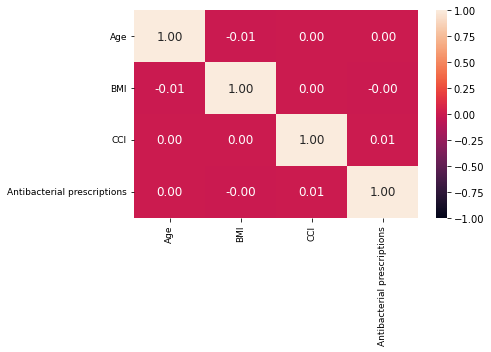

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [35]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'urti_ab_date', 'ab_type_cat', 'incdt_urti_date', 'date', 'period',
                                   'event_urti_admitted', 'duration_urti_admitted'
                                    ]]

In [36]:
#incident and prevalent infection 
data_urti_incdt = data_urti[data_urti['incdt_urti_date'] == 0]
data_urti_prevl = data_urti[data_urti['incdt_urti_date'] == 1]
#switch variable urti_ab_date into a binary variable
data_urti_incdt[['urti_ab_date']] = data_urti_incdt[['urti_ab_date']].where(data_urti_incdt[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_urti_prevl[['urti_ab_date']] = data_urti_prevl[['urti_ab_date']].where(data_urti_prevl[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)

# #incident and prevalent infection stratified by sex categories
# data_urti_incdt_males = data_urti_incdt[data_urti_incdt['sex'] == 'male']
# data_urti_incdt_females = data_urti_incdt[data_urti_incdt['sex'] == 'female']
# data_urti_prevl_males = data_urti_prevl[data_urti_prevl['sex'] == 'male']
# data_urti_prevl_females = data_urti_prevl[data_urti_prevl['sex'] == 'female']

# #incident and prevalent infection stratified by age categories
# data_urti_incdt_15_24 = data_urti_incdt[data_urti_incdt['age_cat'] == '15_24']
# data_urti_incdt_25_34 = data_urti_incdt[data_urti_incdt['age_cat'] == '25_34']
# data_urti_incdt_35_44 = data_urti_incdt[data_urti_incdt['age_cat'] == '35_44']
# data_urti_incdt_45_54 = data_urti_incdt[data_urti_incdt['age_cat'] == '45_54']
# data_urti_incdt_55_64 = data_urti_incdt[data_urti_incdt['age_cat'] == '55_64']
# data_urti_incdt_65_74 = data_urti_incdt[data_urti_incdt['age_cat'] == '65_74']
# data_urti_incdt_75_more = data_urti_incdt[data_urti_incdt['age_cat'] == '75_more']
# data_urti_prevl_15_24 = data_urti_prevl[data_urti_prevl['age_cat'] == '15_24']
# data_urti_prevl_25_34 = data_urti_prevl[data_urti_prevl['age_cat'] == '25_34']
# data_urti_prevl_35_44 = data_urti_prevl[data_urti_prevl['age_cat'] == '35_44']
# data_urti_prevl_45_54 = data_urti_prevl[data_urti_prevl['age_cat'] == '45_54']
# data_urti_prevl_55_64 = data_urti_prevl[data_urti_prevl['age_cat'] == '55_64']
# data_urti_prevl_65_74 = data_urti_prevl[data_urti_prevl['age_cat'] == '65_74']
# data_urti_prevl_75_more = data_urti_prevl[data_urti_prevl['age_cat'] == '75_more']

# #incident and prevalent infection stratified by time period categories
# data_urti_incdt_prepandemic = data_urti_incdt[data_urti_incdt['date'] <= '2019-12']
# data_urti_incdt_during_pandemic = data_urti_incdt[(data_urti_incdt['date'] >= '2020-03') & (data_urti_incdt['date']<= '2021-03')]
# data_urti_incdt_post_2nd_lockdown = data_urti_incdt[data_urti_incdt['date'] <= '2021-04']
# data_urti_prevl_prepandemic = data_urti_prevl[data_urti_prevl['date'] <= '2019-12']
# data_urti_prevl_during_pandemic = data_urti_prevl[(data_urti_prevl['date'] >= '2020-03') & (data_urti_prevl['date']<= '2021-03')]
# data_urti_prevl_post_2nd_lockdown = data_urti_prevl[data_urti_prevl['date'] <= '2021-04']

# # no antibiotics and incident hospital admission
# data_urti_no_abs_incdt = data_urti[data_urti['urti_ab_date'].isnull()]
# data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# # with antibiotics and incident hospital admission
# data_urti_abs_incdt = data_urti[data_urti['urti_ab_date'].notnull()]
# data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# # no antibiotics and prevalent hospital admission
# data_urti_no_abs_prevl = data_urti[data_urti['urti_ab_date'].isnull()]
# data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# # with antibiotics and prevalent hospital admission
# data_urti_abs_prevl = data_urti[data_urti['urti_ab_date'].notnull()]
# data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

In [37]:
#store data for plotting hosp admission counts and percentages
%store data_urti
# save data
data_urti.to_csv('../output/hospitalisation_prediction_urti/data_urti.csv')

Stored 'data_urti' (DataFrame)


## 5- cox modelling for hospital admissions

In [38]:
#build cox models 
data_urti_incdt_enc = cox_data_prep(data_urti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period'], ['antibacterial_brit', 'urti_ab_date'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'incdt', data_urti_incdt_enc)

#make summary table of cases
make_summary_table_cases('urti', 'incdt', data_urti_incdt)

#build cox model
cph, data_urti_incdt_dev, data_urti_incdt_val = cox_model_abs_build('urti', 'incdt', data_urti_incdt)

#calculate c-statistics
cox_output(cph, 'urti', 'incdt', data_urti_incdt_dev, data_urti_incdt_val, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')

<lifelines.CoxPHFitter: fitted with 119484 total observations, 118656 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 119484
number of events observed = 828
   partial log-likelihood = -9652.37
         time fit was run = 2023-05-26 18:05:34 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.14       0.87       0.10            -0.34             0.07                 0.71                 1.07
CCI_cat[T.medium]        -0.00       1.00       0.11            -0.22             0.22                 0.80                 1.24
CCI_cat[T.high]           0.02       1.02       0.13            -0.25             0.28                 0.78                 1.32
CCI_cat[T.very_high]     -0.02       0.98       0.12            -0.25             0.21                 0.78                 1.24
age_cat[T.25_34]          0.25       1.28       0.13            -0.01             0.51                 0.99                 1.66
age_cat[T.35_44]          0.15       1.16       0.13            -0.12             0.41                 0.89                 1.51
age_cat[T.45_54]          0.27       1.31       0.13             0.02             0.53                 1.02                 1.69
age_cat[T.55_64]          0.12       1.13       0.13            -0.14             0.39                 0.87                 1.47
age_cat[T.65_74]          0.13       1.14       0.13            -0.13             0.40                 0.88                 1.49
age_cat[T.75_more]       -0.06       0.94       0.14            -0.34             0.21                 0.71                 1.24
antibacterial_brit        0.00       1.00       0.02            -0.05             0.05                 0.95                 1.05
bmi_cat[T.obese]          0.01       1.01       0.13            -0.24             0.26                 0.78                 1.30
bmi_cat[T.overweight]    -0.03       0.97       0.16            -0.34             0.28                 0.71                 1.32
bmi_cat[T.underweight]    0.32       1.38       0.20            -0.07             0.72                 0.93                 2.05
bmi_cat[T.unknown]       -0.18       0.84       0.14            -0.45             0.10                 0.64                 1.10
ethnicity[T.other]       -0.19       0.83       0.20            -0.57             0.19                 0.56                 1.21
ethnicity[T.unknown]      0.16       1.18       0.15            -0.13             0.45                 0.88                 1.57
ethnicity[T.white]        0.06       1.07       0.14            -0.21             0.34                 0.81                 1.40
flu_vaccine[T.yes]       -0.04       0.96       0.12            -0.27             0.19                 0.76                 1.21
imd[T.medium]             0.17       1.19       0.11            -0.05             0.39                 0.96                 1.48
imd[T.unaffluent]         0.03       1.03       0.12            -0.20             0.26                 0.82                 1.30
imd[T.unknown]           -0.42       0.66       0.22            -0.84             0.01                 0.43                 1.01
imd[T.very_affluent]      0.07       1.08       0.12            -0.15             0.30                 0.86                 1.35
imd[T.very_unaffluent]    0.17       1.19       0.11            -0.05             0.39                 0.96                 1.48
region[T.east_midlands]   0.05       1.05       0.16            -0.25             0.36                 0.78                 1.43
region[T.london]          0.02       1.02       0.14            -0.24             0.29                 0.79           

13286


In [39]:
#build cox models 
data_urti_prevl_enc = cox_data_prep(data_urti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period'], ['antibacterial_brit', 'urti_ab_date'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'prevl', data_urti_prevl_enc)

#make summary table of cases
make_summary_table_cases('urti', 'prevl', data_urti_prevl)

#build cox model
cph, data_urti_prevl_dev, data_urti_prevl_val = cox_model_abs_build('urti', 'prevl', data_urti_prevl)
    
#calculate c-statistics
cox_output(cph, 'urti', 'prevl', data_urti_prevl_dev, data_urti_prevl_val, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')

<lifelines.CoxPHFitter: fitted with 13508 total observations, 13408 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 13508
number of events observed = 100
   partial log-likelihood = -936.39
         time fit was run = 2023-05-26 18:05:39 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.28       0.75       0.28            -0.83             0.27                 0.44                 1.31
CCI_cat[T.medium]        -0.19       0.83       0.31            -0.79             0.42                 0.45                 1.52
CCI_cat[T.high]          -0.47       0.63       0.42            -1.28             0.35                 0.28                 1.42
CCI_cat[T.very_high]     -0.18       0.83       0.33            -0.82             0.46                 0.44                 1.58
age_cat[T.25_34]         -0.53       0.59       0.37            -1.25             0.20                 0.29                 1.22
age_cat[T.35_44]         -0.16       0.85       0.34            -0.82             0.51                 0.44                 1.66
age_cat[T.45_54]         -0.65       0.52       0.39            -1.41             0.12                 0.24                 1.13
age_cat[T.55_64]         -0.11       0.90       0.33            -0.76             0.55                 0.47                 1.73
age_cat[T.65_74]         -0.18       0.83       0.34            -0.85             0.48                 0.43                 1.62
age_cat[T.75_more]       -0.63       0.53       0.39            -1.39             0.14                 0.25                 1.15
antibacterial_brit       -0.07       0.93       0.07            -0.21             0.07                 0.81                 1.08
bmi_cat[T.obese]          0.35       1.42       0.47            -0.58             1.27                 0.56                 3.56
bmi_cat[T.overweight]    -0.04       0.96       0.59            -1.19             1.10                 0.30                 3.02
bmi_cat[T.underweight]    1.14       3.12       0.59            -0.01             2.29                 0.99                 9.85
bmi_cat[T.unknown]        0.69       2.00       0.48            -0.25             1.63                 0.78                 5.13
ethnicity[T.other]       -0.02       0.98       0.54            -1.07             1.02                 0.34                 2.78
ethnicity[T.unknown]      0.19       1.20       0.42            -0.64             1.01                 0.52                 2.76
ethnicity[T.white]        0.00       1.00       0.40            -0.78             0.79                 0.46                 2.20
flu_vaccine[T.yes]       -0.18       0.83       0.35            -0.87             0.50                 0.42                 1.65
imd[T.medium]             0.07       1.07       0.30            -0.53             0.66                 0.59                 1.93
imd[T.unaffluent]        -0.13       0.88       0.32            -0.76             0.50                 0.47                 1.64
imd[T.unknown]            0.04       1.04       0.46            -0.87             0.95                 0.42                 2.58
imd[T.very_affluent]     -0.18       0.83       0.32            -0.81             0.45                 0.44                 1.56
imd[T.very_unaffluent]   -0.38       0.68       0.35            -1.06             0.30                 0.35                 1.35
region[T.east_midlands]   0.02       1.02       0.50            -0.97             1.00                 0.38                 2.71
region[T.london]          0.21       1.23       0.42            -0.62             1.03                 0.54               

13296


## 6- Logistic modelling for prescribing antibiotic

### 5-1- incident urti

LR coefficients:
                                           lr_coef
bins_(-2.7000000000000006e-05, 0.00323] -1.835691
bins_(0.00323, 0.00407]                 -2.007194
bins_(0.00407, 0.00482]                 -2.095357
bins_(0.00482, 0.00558]                 -2.110800
bins_(0.00558, 0.00641]                 -2.197969
bins_(0.00641, 0.00736]                 -2.259972
bins_(0.0101, 0.0128]                   -2.317032
bins_(0.00736, 0.00853]                 -2.324319
bins_(0.00853, 0.0101]                  -2.367246
bins_(0.0128, 0.0634]                   -2.520993

RF parameters after grid search: RandomForestClassifier(max_depth=25, max_leaf_nodes=50, n_estimators=500)

RF feature importance:
                                           rf_coef
bins_(-2.7000000000000006e-05, 0.00323]  0.428397
bins_(0.0128, 0.0634]                    0.194067
bins_(0.00323, 0.00407]                  0.114160
bins_(0.00853, 0.0101]                   0.063989
bins_(0.00407, 0.00482]                  0.045343

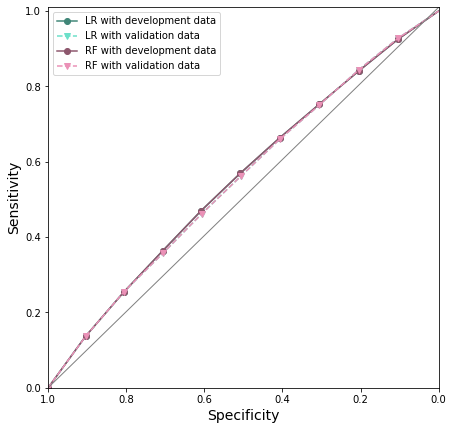

AttributeError: 'int' object has no attribute 'round'

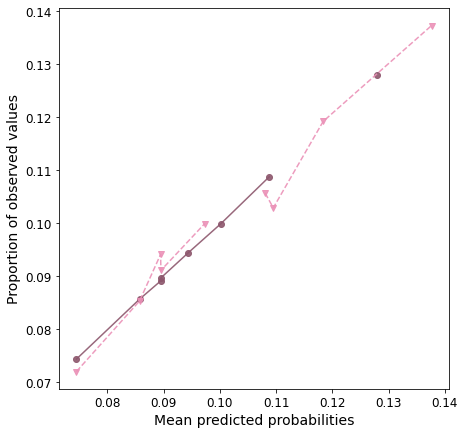

In [40]:
#build lr and rf models with additional predictor of risk deciles
lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val, data_urti_incdt_dev_y, data_urti_incdt_val_y = build_lr_rf_model_with_risk_deciles('urti', 'incdt', data_urti_incdt_dev, data_urti_incdt_val, cph)
#evaluate lr and rf models
lr_rf_roc_ci('urti', 'incdt', data_urti_incdt_dev_y, data_urti_incdt_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)
#lr and rf calibrations
lr_rf_calibration('urti', 'incdt', data_urti_incdt_dev_y, data_urti_incdt_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)

### 5-2- prevalent urti

LR coefficients:
                                          lr_coef
bins_(0.00013999999999999993, 0.00323] -1.816151
bins_(0.00411, 0.00487]                -1.965510
bins_(0.00323, 0.00411]                -2.050621
bins_(0.00564, 0.00643]                -2.181695
bins_(0.00487, 0.00564]                -2.230589
bins_(0.00734, 0.00852]                -2.230589
bins_(0.00643, 0.00734]                -2.257032
bins_(0.00852, 0.0101]                 -2.265692
bins_(0.0101, 0.0128]                  -2.515778
bins_(0.0128, 0.0672]                  -2.651817

LR AUROC with development and validation data: 0.56 and 0.54


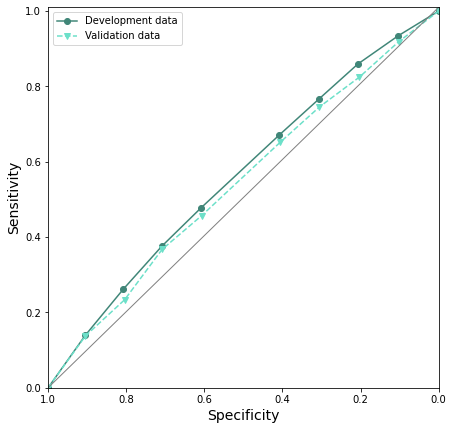

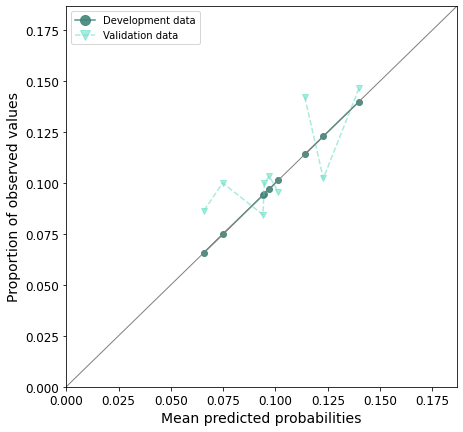

In [ ]:
#build lr and rf models with additional predictor of risk deciles
lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val, data_urti_prevl_dev_y, data_urti_prevl_val_y = build_lr_rf_model_with_risk_deciles('urti', 'prevl', data_urti_prevl_dev, data_urti_prevl_val, cph)
#evaluate lr and rf models
lr_rf_roc_ci('urti', 'prevl', data_urti_prevl_dev_y, data_urti_prevl_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)
#lr and rf calibrations
lr_rf_calibration('urti', 'prevl', data_urti_prevl_dev_y, data_urti_prevl_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)
